In [1]:
"""
# Decision Tree Regression — NACA 4-Digit Airfoils

**Dataset:** AirfRANS (NACA 4-digit series only — 489 samples)
**Features:** Reynolds number, angle of attack, camber, camber position, thickness
**Target:** Lift-to-Drag ratio (L/D)

Decision trees can capture nonlinear relationships via recursive partitioning.
Key hyperparameters:
- **max_depth:** Maximum tree depth (controls complexity)
- **min_samples_leaf:** Minimum samples required in a leaf node (regularization)
"""
from __future__ import annotations


from pathlib import Path
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error


# ─────────────────────────────────────────────────────────────────────────────
# Setup paths
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")


REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split


# ─────────────────────────────────────────────────────────────────────────────
# Load NACA 4-digit dataset
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'


train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean NACA 4-digit features
feature_cols = ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']
target_col = 'L_D'

FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Thickness (%)',
}


X_train = train_df[feature_cols]
y_train = np.asarray(train_df[target_col]).reshape(-1)
X_test = test_df[feature_cols]
y_test = np.asarray(test_df[target_col]).reshape(-1)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")


# ─────────────────────────────────────────────────────────────────────────────
# Preprocessing (trees don't need scaling, but keep for consistency)
# ─────────────────────────────────────────────────────────────────────────────
pre = Pipeline([
    ('scaler', StandardScaler()),
])


def fit_eval(max_depth: int | None, min_samples_leaf: int) -> dict:
    """Train Decision Tree with given hyperparameters."""
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
    )
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
    y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
    
    n_train, p = X_train.shape
    n_test = len(y_test)
    
    r2_tr = float(r2_score(y_train, y_train_pred))
    r2_te = float(r2_score(y_test, y_test_pred))
    
    # Adjusted R²
    r2_adj_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)
    r2_adj_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)
    
    rmse_te = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    return {
        'max_depth': max_depth if max_depth is not None else -1,
        'min_samples_leaf': min_samples_leaf,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'r2_adj_train': r2_adj_tr,
        'r2_adj_test': r2_adj_te,
        'rmse_test': rmse_te,
        'gap': r2_tr - r2_te,
    }

Training samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']


In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# 2D Grid Search: max_depth × min_samples_leaf
# ─────────────────────────────────────────────────────────────────────────────
depths = [2, 3, 4, 5, 7, 10, 15, 20, None]
min_samples = [1, 2, 5, 10, 20, 30]

rows = []
for d in depths:
    for leaf in min_samples:
        rows.append(fit_eval(d, leaf))

results = pd.DataFrame(rows)
results['max_depth_label'] = results['max_depth'].replace({-1: 'None'}).astype(str)

# Best result
best = results.loc[results['r2_adj_test'].idxmax()]
print(f"\nBest configuration:")
print(f"  max_depth = {best['max_depth_label']}, min_samples_leaf = {int(best['min_samples_leaf'])}")
print(f"  Train R² adj = {best['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best['r2_adj_test']:.4f}")
print(f"  RMSE (test)  = {best['rmse_test']:.2f}")
print(f"  Overfit gap  = {best['gap']:.4f}")

results[['max_depth_label', 'min_samples_leaf', 'r2_adj_train', 'r2_adj_test', 'rmse_test', 'gap']].sort_values('r2_adj_test', ascending=False).head(10)


Best configuration:
  max_depth = 20, min_samples_leaf = 1
  Train R² adj = 1.0000
  Test R² adj  = 0.9192
  RMSE (test)  = 9.39
  Overfit gap  = 0.0771


,max_depth_label,min_samples_leaf,r2_adj_train,r2_adj_test,rmse_test,gap
42,20,1,1.000000,0.919176,9.389609,0.077150
48,None,1,1.000000,0.919176,9.389609,0.077150
30,10,1,0.999141,0.918947,9.402938,0.076521
36,15,1,1.000000,0.916711,9.531755,0.079503
24,7,1,0.986234,0.908449,9.993313,0.073806
25,7,2,0.983375,0.894346,10.735473,0.084447
31,10,2,0.992819,0.890144,10.946893,0.097777
37,15,2,0.993022,0.890073,10.950395,0.098044
49,None,2,0.993022,0.890073,10.950395,0.098044
43,20,2,0.993022,0.890073,10.950395,0.098044


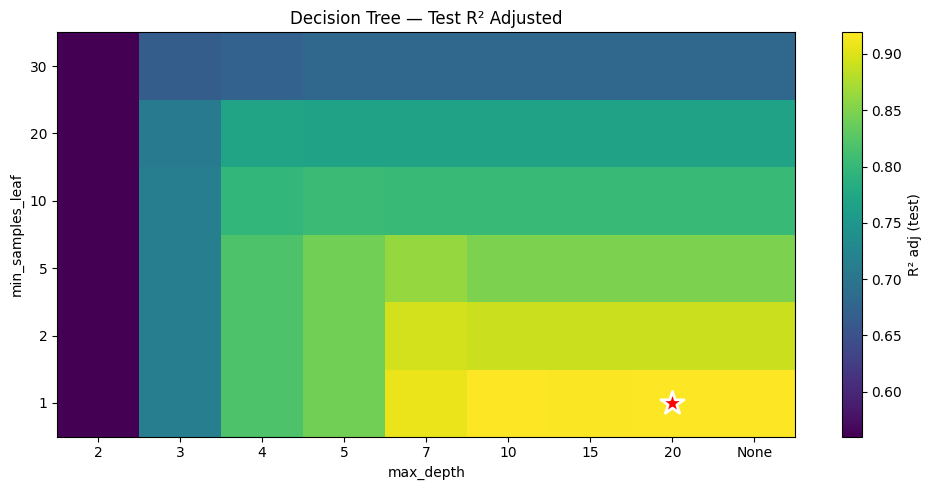


★ Best: max_depth=20, min_samples_leaf=1 → R² = 0.9192


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Heatmap of Test R² (max_depth × min_samples_leaf)
# ─────────────────────────────────────────────────────────────────────────────
pivot = results.pivot(index='min_samples_leaf', columns='max_depth_label', values='r2_adj_test')
# Sort columns properly
col_order = ['2', '3', '4', '5', '7', '10', '15', '20', 'None']
pivot = pivot[[c for c in col_order if c in pivot.columns]]

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')

ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)

ax.set_xlabel('max_depth')
ax.set_ylabel('min_samples_leaf')
ax.set_title('Decision Tree — Test R² Adjusted')

# Mark best point
best_row_idx = list(pivot.index).index(best['min_samples_leaf'])
best_col_idx = list(pivot.columns).index(best['max_depth_label'])
ax.scatter([best_col_idx], [best_row_idx], marker='*', s=300, c='red', edgecolors='white', linewidths=2)

plt.colorbar(im, label='R² adj (test)')
plt.tight_layout()
plt.show()

print(f"\n★ Best: max_depth={best['max_depth_label']}, min_samples_leaf={int(best['min_samples_leaf'])} → R² = {best['r2_adj_test']:.4f}")

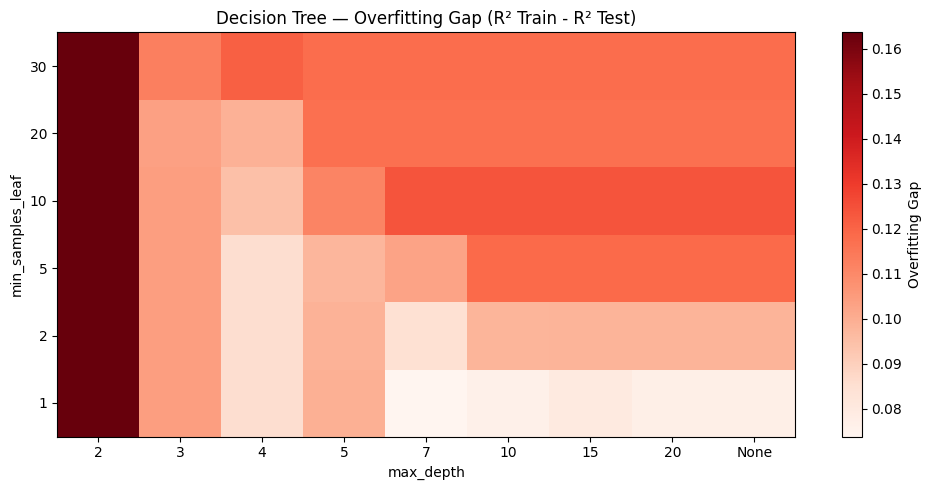


Observation: High depth + low min_samples_leaf → severe overfitting (gap > 0.5)


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Overfitting Gap Heatmap (Train R² - Test R²)
# ─────────────────────────────────────────────────────────────────────────────
pivot_gap = results.pivot(index='min_samples_leaf', columns='max_depth_label', values='gap')
pivot_gap = pivot_gap[[c for c in col_order if c in pivot_gap.columns]]

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot_gap.values, aspect='auto', cmap='Reds', origin='lower')

ax.set_xticks(range(len(pivot_gap.columns)))
ax.set_xticklabels(pivot_gap.columns)
ax.set_yticks(range(len(pivot_gap.index)))
ax.set_yticklabels(pivot_gap.index)

ax.set_xlabel('max_depth')
ax.set_ylabel('min_samples_leaf')
ax.set_title('Decision Tree — Overfitting Gap (R² Train - R² Test)')

plt.colorbar(im, label='Overfitting Gap')
plt.tight_layout()
plt.show()

print("\nObservation: High depth + low min_samples_leaf → severe overfitting (gap > 0.5)")

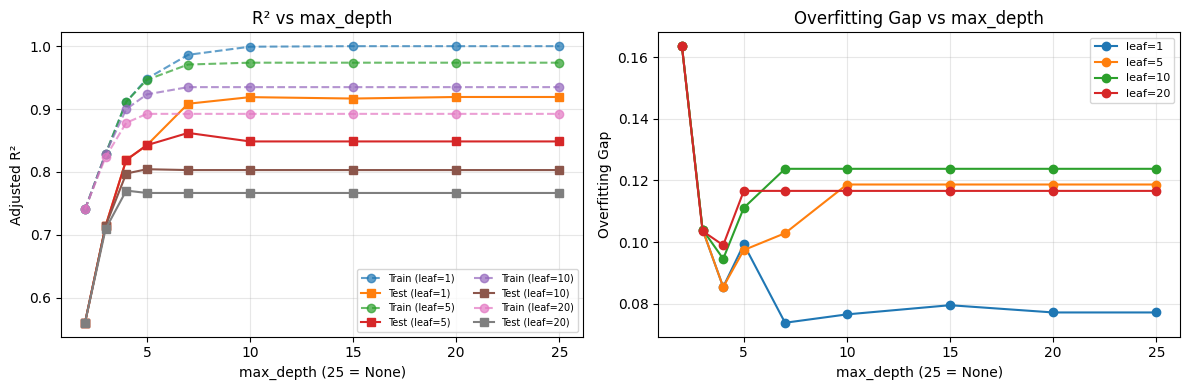

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 3: R² vs max_depth at different min_samples_leaf
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Convert max_depth for plotting (None → 25 for visualization)
results['depth_plot'] = results['max_depth'].replace({-1: 25})

for leaf in [1, 5, 10, 20]:
    subset = results[results['min_samples_leaf'] == leaf]
    axes[0].plot(subset['depth_plot'], subset['r2_adj_train'], 'o--', label=f'Train (leaf={leaf})', alpha=0.7)
    axes[0].plot(subset['depth_plot'], subset['r2_adj_test'], 's-', label=f'Test (leaf={leaf})')

axes[0].set_xlabel('max_depth (25 = None)')
axes[0].set_ylabel('Adjusted R²')
axes[0].set_title('R² vs max_depth')
axes[0].legend(fontsize=7, ncol=2)
axes[0].grid(True, alpha=0.3)

# Right: Gap vs depth
for leaf in [1, 5, 10, 20]:
    subset = results[results['min_samples_leaf'] == leaf]
    axes[1].plot(subset['depth_plot'], subset['gap'], 'o-', label=f'leaf={leaf}')

axes[1].set_xlabel('max_depth (25 = None)')
axes[1].set_ylabel('Overfitting Gap')
axes[1].set_title('Overfitting Gap vs max_depth')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Conclusions (Decision Tree Only)

### Final Decision Tree Metrics (Best Observed)
- `max_depth`: 20
- `min_samples_leaf`: 1
- Train adjusted $R^2$: 1.000000
- Test adjusted $R^2$: 0.919176
- Test RMSE: 9.389609
- Overfit gap (train − test): 0.077150

### Key Deductions
- The tree achieves strong test performance, indicating that piecewise, rule-based partitioning can represent important nonlinear structure in $L/D$ using the five aerodynamic/geometry features.
- The perfect (or near-perfect) training fit alongside a non-trivial train–test gap indicates the model is still high-variance: the tree can memorize fine-grained splits that do not generalize fully.
- This sensitivity to variance is expected for a single tree on a small dataset; constraining depth and/or increasing `min_samples_leaf` can reduce overfitting at the cost of some accuracy.